<div align="center">
    <h1>DS-210: Programming for Data Science</h1>
    <h1>Lecture 10</h1>
</div>

# 1. Memory management in vectors
# 2. Hash maps
# 3. Hash maps with custom types

# <font color="red">1. Memory management in vectors</font>
# 2. Hash maps
# 3. Hash maps with custom types

## Last time: vectors `Vec<T>`

* Dynamic-length array/list 
* Allowed operations:
  * access item at specific location
  * `push`: add something to the end
  * `pop`: remove an element from the end



* Python: list
* C++: `vector<T>`
* Java: `ArrayList<T>` / `Vector<T>`


<div align="center">
    <h3>How to implement this efficiently?</h3>
</div>

## Select implementation details

### Challenges

* Size changes: allocate on the heap?
* What to do if a new element added?
  * Allocate a larger array and copy everything? 
  * Linked list?

### Solution

* Allocate more space than needed!
* When out of space:
  * Increase storage size by, say, 100%
  * Copy everything

### Under the hood
Variable of type `Vec<T>` contains:
* pointer to allocated memory
* size: the current number of items
* capacity: how many items could currently fit

**Important:** size${}\le{}$capacity

## Example

Method `capacity()` reports the current storage size

In [23]:
// print out the current size and capacity
fn info<T>(vector:&Vec<T>) {
    println!("size = {}, capacity = {}",vector.len(),vector.capacity());
}

In [24]:
let mut v = Vec::with_capacity(7);
let mut capacity = v.capacity();
info(&v);
for i in 1..=1000 {
    v.push(i);
    if v.capacity() != capacity {
        capacity = v.capacity();
        info(&v);
    }
};
info(&v);

size = 0, capacity = 7
size = 8, capacity = 14
size = 15, capacity = 28
size = 29, capacity = 56
size = 57, capacity = 112
size = 113, capacity = 224
size = 225, capacity = 448
size = 449, capacity = 896
size = 897, capacity = 1792
size = 1000, capacity = 1792


In [25]:
info(&v);
while let Some(_) = v.pop() {}
info(&v);

size = 1000, capacity = 1792
size = 0, capacity = 1792


## Example (continued)

In [26]:
// shrinking the size manually
info(&v);

for i in 1..=13 {
    v.push(i);
}

info(&v);

v.shrink_to_fit();

info(&v);
// note: size and capacity not guaranteed
//       to be the same

size = 0, capacity = 1792
size = 13, capacity = 1792
size = 13, capacity = 13


In [27]:
// creating vector with specific capacity
let mut v2 : Vec<i32> = Vec::with_capacity(1234);
info(&v2);

// avoids reallocation if you know how many items
// to expect

size = 0, capacity = 1234


In [28]:
// Does not remove from the vector
println!("{:?} {:?}", v.get(1), v);
// But this one does
println!("{:?} {:?}", v.pop(), v);

Some(2) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Some(13) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


### Some other useful functions
* `append` Add vector at the end of another `vec.append(&mut vec2)
* `clear` Remove all elements from the vector `vec.clear`
* `dedup` Remove consecutive identical elements `vec.dedup()`
* `drain` Remove a slice from the vector `vec.drain(2..4)`
* `remove` Remove an element from the vector `vec.remove(2)`
* `sort` Sort the elements of a mutable vector `vec.sort()`
* Complete list at https://doc.rust-lang.org/std/vec/struct.Vec.html

## Sketch of analysis: Amortization

* Inserting an element not constant time, $O(1)$

### However
* **Assumption:** allocating memory size $t$ takes $O(t)$ or $O(1)$ time


* **Slow operations:** <font color="red">$O($current_size$)$ time</font>
* **Fast operations:** <font color="green">$O(1)$ time</font>


* Slow operation every $\Omega($current_size$)$ fast operations

* **On average:** $O(1)$ time
* Fast operations pay for slow operations


* **Terminology:** $O(1)$ *amortized* time


### Shrinking?

* Can be implemented this way too
* Example: shrink by 50% if less than 25% used
* Most implementations don't shrink automatically

<font size=4>
$O(n)$ -> Algorithm takes no more than n time (worst case scenario)
<p>
$\Omega(n)$ -> Algorithm takes at least n time (best case scenario)  
<p>
$\Theta(n)$ -> Average/Typical running time for the algorithm (average case scenario)  
</font>

## Digression (Sorting Vectors in Rust)

In [12]:
// This works great
let mut a = vec![1, 4, 3, 6, 8, 12, 5];
a.sort();
println!("{:?}", a);

[1, 3, 4, 5, 6, 8, 12]


In [29]:
// But the compiler does not like this one, since sort depends on total order
let mut a = vec![1.0, 4.0, 3.0, 6.0, 8.0, 12.0, 5.0];
a.sort();
println!("{:?}", a);

Error: the trait bound `{float}: Ord` is not satisfied

In [30]:
// This is ok since we don't use sort, sort_by depends on the function you pass in to compute order
let mut a: Vec<f32> = vec![1.0, 4.0, 3.0, 6.0, 8.0, 12.0, 5.0];
// a.sort();
a.sort_by(|x, y| x.partial_cmp(y).unwrap());
println!("{:?}", a);

[1.0, 3.0, 4.0, 5.0, 6.0, 8.0, 12.0]


In [6]:
// When partial order is not well defined in the inputs you get a panic
let mut a = vec![1.0, 4.0, 3.0, 6.0, 8.0, 12.0, 5.0];
let mut x: f32 = -1.0;
x = x.sqrt();
a.push(x);
println!("{:?}", a);
a.sort_by(|x, y| x.partial_cmp(y).unwrap());
println!("{:?}", a);

[1.0, 4.0, 3.0, 6.0, 8.0, 12.0, 5.0, NaN]


thread '<unnamed>' panicked at 'called `Option::unwrap()` on a `None` value', src/lib.rs:102:35
stack backtrace:
   0: _rust_begin_unwind
   1: core::panicking::panic_fmt
   2: core::panicking::panic
   3: alloc::slice::insert_head
   4: alloc::slice::merge_sort
   5: <core::panic::unwind_safe::AssertUnwindSafe<F> as core::ops::function::FnOnce<()>>::call_once
   6: _run_user_code_3
   7: evcxr::runtime::Runtime::run_loop
   8: evcxr::runtime::runtime_hook
   9: evcxr_jupyter::main
note: Some details are omitted, run with `RUST_BACKTRACE=full` for a verbose backtrace.


# 1. Memory management in vectors
# <font color="red">2. Hash maps</font>

## Collection `HashMap<K,V>`

**Goal:** a mapping from elements of `K` to elements of `V`

* elements of `K` called *keys*

* elements of `V` called *values*


* Python: dictionaries
* C++: `unordered_map<K,V>`
* Java: `Hashtable<K,T>`


In [31]:
// creating a hash map and inserting pair

use std::collections::HashMap;

// number of wins in a local Conterstrike league
let mut wins = HashMap::<String,u16>::new();

wins.insert(String::from("Boston University"),24);
wins.insert(String::from("Harvard"),22);
wins.insert(String::from("Boston College"),20);
wins.insert(String::from("Northeastern"),32);

Extracting a reference: returns `Option<&V>`

In [32]:
wins.get("Boston University")

Some(24)

In [33]:
wins.get("MIT")

None

Insert if not present:

In [34]:
wins.entry(String::from("MIT")).or_insert(10);
wins.get("MIT")

Some(10)

Updating:

In [35]:
{ // block to limit how long the reference lasts
    let entry = wins.entry(String::from("Boston University")).or_insert(10);
    *entry = 50;
}
// wins.insert(String::from("Boston University"),24);
wins.get("Boston University")

Some(50)

## Iterating

In [36]:
for (k,v) in &wins {
    println!("{}: {}",k,v);
};

for (k,v) in wins.iter() {
    println!("Iter {}: {}",k,v);
};


Harvard: 22
Boston College: 20
Northeastern: 32
MIT: 10
Boston University: 50
Iter Harvard: 22
Iter Boston College: 20
Iter Northeastern: 32
Iter MIT: 10
Iter Boston University: 50


In [37]:
for (k,v) in &mut wins {
    *v += 1;
};

for (k,v) in &wins {
    println!("{}: {}",k,v);
};

for (k,v) in wins.iter_mut() {
    *v += 1;
};

for (k,v) in wins.iter() {
    println!("Mut iter {}: {}",k,v);
};



Harvard: 23
Boston College: 21
Northeastern: 33
MIT: 11
Boston University: 51
Mut iter Harvard: 24
Mut iter Boston College: 22
Mut iter Northeastern: 34
Mut iter MIT: 12
Mut iter Boston University: 52


### Using HashMaps with Match statements

In [22]:
use std::collections::HashMap;

let mut crispy_crêpes_café = HashMap::new();
crispy_crêpes_café.insert(String::from("Nutella Crêpe"),5.85);
crispy_crêpes_café.insert(String::from("Strawberries and Nutella Crêpe"),8.75);
crispy_crêpes_café.insert(String::from("Roma Tomato, Pesto and Spinach Crêpe"),8.90);
crispy_crêpes_café.insert(String::from("Three Mashroom Crêpe"),8.90);

fn on_the_menu(cafe: &HashMap<String,f64>, s:String) {
    print!("{}: ",s);
    match cafe.get(&s) {
        None => println!("not on the menu"),
        Some(price) => println!("${:.2}",price),
    }
}
on_the_menu(&crispy_crêpes_café, String::from("Four Mashroom Crêpe"));
on_the_menu(&crispy_crêpes_café, String::from("Three Mashroom Crêpe"));



Four Mashroom Crêpe: not on the menu
Three Mashroom Crêpe: $8.90


## Storage

* Array representing $B$ buckets
* *Hash function* $h: K \rightarrow \{0,1,\ldots,B-1\}$
  * maps keys in the collection to buckets

### General ideas
  * Store keys (and associated values) in buckets
  * Searching: go over the entire bucket

### Collision: two keys mapped to the same bucket  
  * Make hash function $h$ very random $\Rightarrow$ few collisions
  * What to do if two keys in the same bucket



## Handling collisions

### Chaining

* Keep collection for items in the same bucket
  * (traditional:) linked list
  * vector
* Search through the collection to find key
<br><br><br>

### Open addressing (simplest version)

* Each array entry: $($key$,$value$)$

**Inserting:**
  * entry $h(k)$ busy: try $h(k) + 1$, $h(k) + 2$, etc. 
  * insert into first empty


**Searching:**
  * try $h(k)$, $h(k) + 1$, $h(k)+2$, etc.
  * stop when found or empty entry

## Growing collection: amortization

Example: if number of keys${}\ge 0.75 B$
* Double $B$
* Pick new hash function
* Move the information

## Adversarial data

* Could create lots of collisions

* Potential basis for *denial of service attacks*

### What makes a good hash function?

* Uniform distribution of inputs to the buckets available!!!
* Consistent hashing adds the property that not too many things move around when the number of buckets changes

http://www.partow.net/programming/hashfunctions/index.html  
https://en.wikipedia.org/wiki/Consistent_hashing  
https://doc.rust-lang.org/std/collections/struct.HashMap.html  

## Hashing with custom types in Rust

Required for hashing:
  1. check if $k_1,k_2 \in {}$`K` equal
  1. compute a hash function for elements of `K`

In [25]:
use std::collections::HashMap;

struct Point {
    x:i64,
    y:i64,
}

let point = Point{x:2,y:-1};

let mut elevation = HashMap::new();

elevation.insert(point,2.3);


Error: the trait bound `Point: Eq` is not satisfied

Error: the trait bound `Point: Hash` is not satisfied

Need three traits:
  * `Eq`
  * `PartialEq`
  * `Hash`

Default implementation:

In [26]:
use std::collections::HashMap;

#[derive(Debug,Hash,Eq,PartialEq)]
struct DistanceKM(u64);

let mut tired = HashMap::new();

tired.insert(DistanceKM(30),true);
tired

{DistanceKM(30): true}

### All the traits that you can automatically derive from

* Clone: Allow user to make an explicit copy
* Copy: Allow user to make an implicit copy
* Debug: Allow user to print contents
* Default: Allow user to initialize with default values (Default::default())
* Hash: Allow user to use it as a key to a hash map or set.
* Eq: Allow user to test for equality
* Ord: Allow user to sort and fully order types
* PartialEq: Obeys most rules for equality but not all
* PartialOrd: Obeys most rules for ordering but not all

### Not all basic types support the Eq and Hash traits (f32 and f64 do not).  The reasons have to do with the NaN and Infinity problems we discussed last time.  

* If you find yourself needing floats as keys consider converting the float to a collection of integers

In [17]:
:dep num-traits="0.2"

In [5]:
use num_traits::Float;

let num:f64 = 3.14159;  // Some float
let base:f64 = 2.0;
// (8388608, -22, 1)
let (mantissa, exponent, sign) = Float::integer_decode(num);
println!("{} {} {}", mantissa, exponent, sign);
let sign_f:f64 = sign as f64;
let mantissa_f:f64 = mantissa as f64;
let exponent_f:f64 = base.powf(exponent as f64);

// 1 * 8388608 * 2^(-22) == 2
let new_num:f64 = sign_f * mantissa_f * exponent_f;

println!("{:32.31} {:32.31}", num, new_num);


The type of the variable tired was redefined, so was lost.


7074231776675438 -51 1
3.1415899999999998826183400524314 3.1415899999999998826183400524314


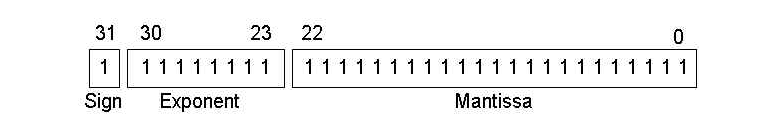

float_num = sign * 1.mantissa * 2^exponent where  
sign is -1 or 1  
mantissa is between 0 and 2^23  
exponent is between -127 and 128  

## `HashSet<K>` 

* No value associated with keys
* Just a set of items
* Same implementation

In [18]:
use std::collections::HashSet;

// create
let mut covid = HashSet::new();

// insert values
for i in 2019..=2022 {
    covid.insert(i);
};

In [19]:
// iterate over values in the set
for year in &covid {
    print!("{} ",year);
}
println!();

2022 2019 2021 2020 


In [20]:
covid.get(&2015)

None

In [21]:
covid.get(&2021)

Some(2021)

In [22]:
covid.insert(2020);
for year in &covid {
    print!("{} ",year);
}
println!();

2022 2019 2021 2020 
